# Build community model

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
plt.rcParams['svg.fonttype'] = 'none'

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16


<Solution 0.12 at 0x7fe1a11b8c50>

In [3]:
# with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
#     me = pickle.load(solution)
with open(ecoli_files+'/me_models/solution_spore.pickle', 'rb') as solution:
    spore = pickle.load(solution)

In [4]:
with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

## Create spore model

### Change IDs (compartment _s)

In [5]:
# Metabolites
new_compartment = 's'
fix = []
for met in tqdm(spore.metabolites):
    if re.search('_[c,e]$',met.id):
        met.id = re.sub('c$',new_compartment,met.id)
    else:
        met.id = met.id+'_'+new_compartment

100%|██████████| 3442/3442 [00:00<00:00, 744586.85it/s]


In [6]:
# Reactions
new_compartment = 's'
fix = []
for r in tqdm(spore.reactions):
        r.id = r.id+'_'+new_compartment

100%|██████████| 5300/5300 [00:00<00:00, 1475985.07it/s]


In [7]:
spore.repair()

In [8]:
# Create new growth key for spore
new_growth_key = 'sigma'
for r in tqdm(spore.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = lb.subs(growth_key,new_growth_key)
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = ub.subs(growth_key,new_growth_key)
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 5300/5300 [00:06<00:00, 808.36it/s] 


In [9]:
# Eliminate exchange reactions:
reactions = [r for r in spore.reactions]
for r in tqdm(reactions):
    if re.search('^EX_',r.id):
        r.remove_from_model()

100%|██████████| 5300/5300 [00:00<00:00, 74188.64it/s]


### Create spore biomass reactions

In [10]:
bio_rxn = spore.reactions.BIOMASS_BS_10_FWD_CPLX_dummy_s

In [11]:
bio_comp = pd.read_csv('spore_composition.csv',index_col=0)

In [12]:
# Identify lipid metabolites in biomass equation
lipid_demand = {}
for m in bio_comp.index:
    if '_BS_c' in m:
        new_id = re.sub('c$','s',m)
        value = bio_comp.loc[m]['coeff']
        lipid_demand[new_id] = abs(value)
                
for met, requirement in lipid_demand.items():
    component_mass = spore.metabolites.get_by_id(met).formula_weight / 1000.
    rxn = cobrame.SummaryVariable('Demand_' + met)
    spore.add_reactions([rxn])
    rxn.add_metabolites({met: -1 * requirement,
                         'lipid_biomass_s': component_mass * requirement})
    rxn.lower_bound = spore.reactions.biomass_dilution_s.lower_bound
    rxn.upper_bound = 1000.
#     print(rxn.reaction)

### Merge

In [13]:
with open(ecoli_files+'/me_models/solution_mother.pickle', 'rb') as solution:
    sporeme = pickle.load(solution)

In [14]:
# Mother is not growing. Reactions should then be associated to sigma
new_growth_key = 'sigma'
for r in tqdm(sporeme.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = float(lb.subs(growth_key,0.))
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = float(ub.subs(growth_key,1000.))
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
            a = 1
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 6288/6288 [00:08<00:00, 718.08it/s] 


In [15]:
# sporeme.add_reactions(spore.reactions) # This approach no longer worked after python version change.

#### Add spore reactions

In [16]:
# Add spore reactions
for r in tqdm(spore.reactions):
    new = r.__class__(r.id) # Create and identical reaction
    new.bounds = r.bounds
    sporeme.add_reaction(new)
    for k,v in r.metabolites.items():
        if not hasattr(sporeme.metabolites,k.id):
            args = k.__init__.__code__.co_varnames[1:] # Eliminate "self"
            if len(args) == 1: # No additional inputs to __init__
                met = k.__class__(k.id)
            else:
                vals = [getattr(k, dir(k)[[i.lower() for i in dir(k)].index(a)]) for a in args]
                met = k.__class__(*vals)
            sporeme.add_metabolites(met)
            met.name = k.name
            met.formula = k.formula
            met.charge = k.charge
            met.compartment = met.id[-1]
            
        new.add_metabolites({k.id:v})

100%|██████████| 5069/5069 [00:03<00:00, 1550.87it/s]


#### Connect C with S
Replace transport reaction S-E with S-C

In [17]:
# # Connect C with S
# ## Change spore transport from e-s to c-s

# ## DEPRECATED as this ignores transport reactions that change the metabolite chemically, such as PTS
# for m in tqdm(sporeme.metabolites):
#     if not isinstance(m,cobrame.Metabolite) or not re.search('_s$',m.id):
#         continue
#     in_transport = get_transport_reactions(sporeme,m.id,comps=['e','s'])
#     out_transport = get_transport_reactions(sporeme,m.id,comps=['s','e'])
#     transport_reactions = in_transport + out_transport
#     for r in transport_reactions:
#         old_met = sporeme.metabolites.get_by_id(re.sub('_s$','_e',m.id))
#         new_met = sporeme.metabolites.get_by_id(re.sub('_s$','_c',m.id))
#         coeff = r.metabolites[old_met]
#         r.add_metabolites({old_met:-coeff,new_met:coeff})

In [18]:
def get_compartments(rxn):
    return [m.compartment for m in rxn.metabolites if isinstance(m,cobrame.core.component.Metabolite)]

In [19]:
rxns = bacillusme.util.helper_functions.get_all_transport_of_model(sporeme)
rxns = set([r for r in rxns if isinstance(sporeme.reactions.get_by_id(r),cobrame.core.reaction.MetabolicReaction)])
for r in tqdm(rxns):
    rxn = sporeme.reactions.get_by_id(r)
    comps = get_compartments(rxn)
    if len(comps) < 2:
        continue
    if set(["e","s"]) - set(comps):
        continue
    
    for m,coeff in rxn.metabolites.items():
        # print(m)
        if m.compartment != "e":
            continue
        new_met_id = re.sub('_e$','_c',m.id)
        if new_met_id not in sporeme.metabolites:
            new_met = cobrame.core.component.Metabolite(new_met_id)
            sporeme.add_metabolites([new_met])
        new_met = sporeme.metabolites.get_by_id(new_met_id)
        rxn.add_metabolites({
            m : -coeff,
            new_met : coeff
        })

100%|██████████| 800/800 [00:00<00:00, 60066.65it/s]


In [20]:
# sporeme.objective = 'biomass_dilution_s'
sporeme.reactions.get_by_id('BIOMASS_BS_10_FWD_CPLX_dummy_s').upper_bound = 0

### Correct spoIIIAA-H - spoIIQ formation

In [21]:
sporeme.reactions.get_by_id('formation_PORE-CPLX').remove_from_model()

In [22]:
old_formation = sporeme.reactions.get_by_id('formation_PORE-CPLX_s')

In [23]:
new_stoich = {}
for k,v in old_formation.metabolites.items():
    if v > 0 or 'BSU36550' in k.id: # spoIIQ is from the spore
        new_stoich[k] = v
        continue
    newk = k.id.split('_s')[0]
    new_stoich[sporeme.metabolites.get_by_id(newk)] = v

In [24]:
new_formation = cobrame.core.reaction.ComplexFormation('formation_combined_PORE-CPLX_s')
sporeme.add_reactions([new_formation])
new_formation.add_metabolites(new_stoich)
print(new_formation.reaction)

12.0 protein_BSU24360_Inner_Membrane + 30.0 protein_BSU24370_Inner_Membrane + protein_BSU24380_Inner_Membrane + protein_BSU24390_Inner_Membrane + protein_BSU24400_Inner_Membrane + protein_BSU24410_Inner_Membrane + protein_BSU24420_Inner_Membrane + 6.0 protein_BSU24430_Inner_Membrane + 12.0 protein_BSU36550_Inner_Membrane_s --> PORE-CPLX_s


In [25]:
old_formation.remove_from_model()

In [26]:
sporeme.reactions.query('formation_.*PORE')

[<ComplexFormation formation_combined_PORE-CPLX_s at 0x7fe103bc2390>]

### Peptidoglycan

##### Spore peptidoglycan precursors are synthesized in the mother cell19 and are flipped across the outer forespore membrane into the intermembrane space by an as yet incompletely understood mechanism20. 
https://www.nature.com/articles/nrmicro2921

Moreover, sigK is responsible for this biosynthesis activation, and it is an MC sigma factor. This makes sigK not essential in the FS anymore

In [27]:
r = sporeme.reactions.get_by_id('biomass_constituent_demand_s')
m = sporeme.metabolites.get_by_id('peptido_BS_s')
newm = sporeme.metabolites.get_by_id('peptido_BS_c')
r.add_metabolites({newm:r.metabolites[m],
                   m:-r.metabolites[m]})
r.metabolites

{<Metabolite 10fthf_s at 0x7fe105bc5bd0>: -0.000367,
 <Metabolite psetha_BS_s at 0x7fe10466ad10>: -0.00056,
 <Constraint constituent_biomass_s at 0x7fe0fc0c0190>: 0.13926027055704,
 <Metabolite peptido_BS_c at 0x7fe0fcc7c790>: -0.101817}

### Close ATP synthase as there is no evidence for it on the spore membrane

In [28]:
for r in sporeme.reactions.query('ATPS.*_s'):
    print(r.id,r.reaction)
    r.bounds = (0,0)
# sporeme.reactions.get_by_id('ATPS4r_FWD_CPLX000-10_s').bounds = (0,0)
# # No glucose uptake from e
# for r in sporeme.reactions.query('GLCpts.*_s'):
#     print(r.id,r.reaction)
#     r.bounds = (0,0)

ATPS4r_REV_PORE-CPLX_s atp_s + h2o_s + 3.0 h_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + adp_s + 4.0 h_c + pi_s
ATPS4r_FWD_PORE-CPLX_s adp_s + 4.0 h_c + pi_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + atp_s + h2o_s + 3.0 h_s


### Change carbon source to glutamate


In [29]:
sporeme.reactions.get_by_id("EX_glc__D_e").bounds = (0,1000)
sporeme.reactions.get_by_id("EX_glu__L_e").bounds = (-2,1000)

### Fixes

In [30]:
for r in sporeme.reactions:
    if r.objective_coefficient:
        r.objective_coefficient = 0
sporeme.reactions.get_by_id("dummy_reaction_FWD_SPONT_s").objective_coefficient = 1

### Solve

In [31]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 52.997864 seconds
Finished substituting S,lb,ub in 1.914110 seconds
Finished makeME_LP in 0.264187 seconds
Getting MINOS parameters from ME_NLP...
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling mi

In [32]:
sporeme.name = 'Spore model with spoIIIA-H - spoIIQ pore channel'
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "wb") as outfile:
    pickle.dump(sporeme, outfile)

### Close specific reactions in the spore
Sporulation allows bacteria to survive adverse conditions and is essential to the lifecycle of some obligate anaerobes. In Bacillus subtilis, the sporulation-specific sigma factors, σF, σE, σG, and σK, activate compartment-specific transcriptional programs that drive sporulation through its morphological stages

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4380625/

In [33]:
# From proteomics. ilvE = ybgE
gene_dictionary = pd.read_csv('../../building_data/gene_name_dictionary.csv',index_col=1)

deplete_genes = set(['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf'])
deplete_genes -= set(['sigF']) # sigF and sigG are FS sigma factors
deplete_genes = deplete_genes | set(['sigE', 'sigKc', 'sigKn']) # sigE and sigK are MC sigma factors

deplete_genes = set(gene_dictionary.loc[deplete_genes]['locus_id'])

In [34]:
eliminate_genes = (deplete_genes)
len(eliminate_genes)

15

In [35]:
# # From Eammon's paper.
# # https://www.science.org/doi/10.1126/sciadv.abd6385
# eliminate_genes = ['citB','citZ','icd','sucD','fumC','mdh']
# gene_dictionary.loc[eliminate_genes]['locus_id']

In [36]:
essentiality_df = pd.read_csv('../essentiality/essentiality_results.csv',index_col=0)
eliminate_ids = set(eliminate_genes) & set(essentiality_df.index)
essentiality_df.loc[eliminate_ids]

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU29680,0.000000,0,-1.302820e-10,0,0
BSU30560,0.000000,0,-1.828217e-10,0,0
BSU28310,-0.000009,0,0.000000e+00,0,0
BSU15320,-1.000000,e,NaN,NaN,0
BSU26390,-1.000000,e,NaN,NaN,0
BSU02390,0.000000,0,0.000000e+00,0,0
BSU25760,-1.000000,e,NaN,NaN,0
BSU11200,-1.000000,e,-1.000000e+00,e,0
BSU06480,0.000000,0,-1.000000e+00,e,0
BSU29140,-0.000028,0,0.000000e+00,0,0


In [37]:
for gene in eliminate_ids:
    r = 'translation_' + gene +'_s'
    if r not in sporeme.reactions:
        print(r+" not in model")
        continue
    print(r)
    rxn = sporeme.reactions.get_by_id(r)
    rxn.bounds = (0,0)

translation_BSU29680_s
translation_BSU30560_s
translation_BSU28310_s
translation_BSU15320_s
translation_BSU26390_s
translation_BSU02390_s
translation_BSU25760_s
translation_BSU11200_s
translation_BSU06480_s
translation_BSU29140_s


### Solve

In [38]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 51.884301 seconds
Finished substituting S,lb,ub in 1.823442 seconds
Finished makeME_LP in 0.250800 seconds
Getting MINOS parameters from ME_NLP...
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling mi

In [39]:
sporeme.name = 'Spore model with proteomics constraints and spoIIIA-H - spoIIQ pore channel'
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "wb") as outfile:
    pickle.dump(sporeme, outfile)

In [40]:
import pickle

In [41]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

## Properties

In [42]:
len(sporeme.metabolites.query('.*_s$')),\
len(sporeme.reactions.query('.*_s$')),\
len(sporeme.metabolites.query('protein_BSU\d*_s$'))

(3201, 5069, 731)

In [43]:
len(set(sporeme.metabolites) - set(sporeme.metabolites.query('.*_s$'))),\
len(set(sporeme.reactions) - set(sporeme.reactions.query('.*_s$'))),\
len(sporeme.metabolites.query('protein_BSU\d*[^s]$'))

(4239, 6287, 972)

In [44]:
len(sporeme.metabolites),\
len(sporeme.reactions),\
len(sporeme.metabolites.query('protein_BSU\d*_*s*$'))

(7440, 11356, 1703)

In [45]:
def get_breakdown(me,field):
    count = {}
    for instance in getattr(me,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return pd.DataFrame.from_dict({'count':count})

<AxesSubplot:>

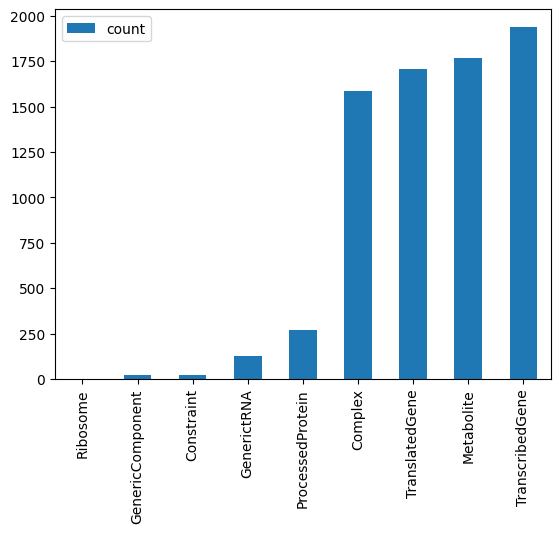

In [46]:
get_breakdown(sporeme,'metabolites').sort_values('count').plot.bar()

<AxesSubplot:>

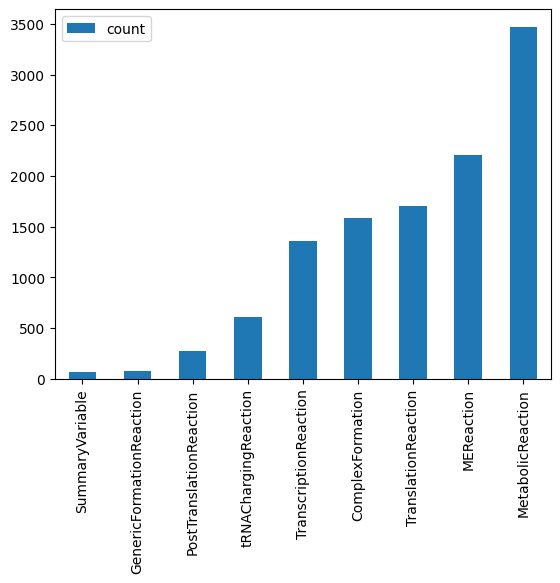

In [47]:
get_breakdown(sporeme,'reactions').sort_values('count').plot.bar()

In [48]:
d = {}
for r in sporeme.reactions:
    try:
        rxn = r.reaction
    except:
        rxn = ''
    d[r.id] = {
        'lower_bound' : r.lower_bound,
        'upper_bound' : r.upper_bound,
        'reaction' : rxn,
        'subsystem' : r.subsystem,
        'flux' : sporeme.solution.x_dict[r.id]
    }

In [49]:
pd.DataFrame.from_dict(d).T.to_csv('Supplementary Files/Supplementary File 1.csv')

### Summary of the model

In [50]:
df = pd.read_csv("../../iYO844_summary.csv",index_col=0)
df.head()

,name,reaction,reaction_with_names,genes
23CN2P1,2 3 cyclic nucleotide 2 phosphodiesterase ...,23camp_c + h2o_c <=> 3amp_c + h_c,"2',3'-Cyclic AMP + H2O H2O <=> 3 AMP C10H12N5...",BSU07840
23CN2P2,2 3 cyclic nucleotide 2 phosphodiesterase ...,23cump_c + h2o_c <=> 3ump_c + h_c,"2',3'-Cyclic UMP + H2O H2O <=> 3 UMP C9H11N2O...",BSU07840
23CN2P3,2 3 cyclic nucleotide 2 phosphodiesterase ...,23ccmp_c + h2o_c <=> 3cmp_c + h_c,"2',3'-Cyclic CMP + H2O H2O <=> 3 CMP C9H12N3O...",BSU07840
23CN2P4,2 3 cyclic nucleotide 2 phosphodiesterase ...,23cgmp_c + h2o_c <=> 3gmp_c + h_c,"2',3'-Cyclic GMP + H2O H2O <=> Guanosine 3 ph...",BSU07840
26DPAi,Dipicolinate synthase,23dhdp_c + nad_c --> DPA_c + h_c + nadh_c,"2,3-Dihydrodipicolinate + Nicotinamide adenine...",BSU16730 and BSU16740


In [51]:
d = {}
for r in sporeme.reactions:
    if not isinstance(r, cobrame.core.reaction.MetabolicReaction):
        continue
    if r.id[-2:] == "_s":
        cell = "spore"
    else:
        cell = "mother"
    baseid = re.split("_FWD_|_REV_",r.id)[0]
    sign = 1 if "FWD" in r.id else -1
    flux = sign * sporeme.solution.x_dict[r.id]
    if baseid not in d:
        d[baseid] = {
            "spore" : 0,
            "mother" : 0
        }
    d[baseid][cell] += flux
flux = pd.DataFrame.from_dict(d).T

In [52]:
df["spore"] = flux["spore"]
df["mother"] = flux["mother"]
df.head()
df = df.fillna({"spore":0, "mother":0})
df = df.fillna("")
df.to_csv("sporeme_metabolic_flux_summary.csv")

In [53]:
df

,name,reaction,reaction_with_names,genes,spore,mother
23CN2P1,2 3 cyclic nucleotide 2 phosphodiesterase ...,23camp_c + h2o_c <=> 3amp_c + h_c,"2',3'-Cyclic AMP + H2O H2O <=> 3 AMP C10H12N5...",BSU07840,0.0,0.000000e+00
23CN2P2,2 3 cyclic nucleotide 2 phosphodiesterase ...,23cump_c + h2o_c <=> 3ump_c + h_c,"2',3'-Cyclic UMP + H2O H2O <=> 3 UMP C9H11N2O...",BSU07840,0.0,0.000000e+00
23CN2P3,2 3 cyclic nucleotide 2 phosphodiesterase ...,23ccmp_c + h2o_c <=> 3cmp_c + h_c,"2',3'-Cyclic CMP + H2O H2O <=> 3 CMP C9H12N3O...",BSU07840,0.0,0.000000e+00
23CN2P4,2 3 cyclic nucleotide 2 phosphodiesterase ...,23cgmp_c + h2o_c <=> 3gmp_c + h_c,"2',3'-Cyclic GMP + H2O H2O <=> Guanosine 3 ph...",BSU07840,0.0,0.000000e+00
26DPAi,Dipicolinate synthase,23dhdp_c + nad_c --> DPA_c + h_c + nadh_c,"2,3-Dihydrodipicolinate + Nicotinamide adenine...",BSU16730 and BSU16740,0.0,0.000000e+00
...,...,...,...,...,...,...
CU2abc1,,atp_c + cu2_e + h2o_c --> adp_c + cu2_c + h_c ...,ATP C10H12N5O13P3 + Copper + H2O H2O --> ADP C...,BSU33500,0.0,0.000000e+00
COBALTt5,Cobalt(II) transport via diffusion,cobalt2_e --> cobalt2_c,Co2+ --> Co2+,,0.0,2.260707e-09
ETOHtex,Ethanol transport via diffusion,etoh_e --> etoh_c,Ethanol --> Ethanol,,0.0,0.000000e+00
EX_cbl1_e,,cbl1_e <=>,<=>,,0.0,0.000000e+00


In [54]:
2

2